In [20]:
import numpy as np
import pandas as pd
from pandas import *
import matplotlib.pyplot as plt
import xgboost as xgb # model
import time
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [54]:
data = pd.read_csv("creditcard.csv")
#data = pd.read_csv("ccfraud_10_features_1968.csv",index_col=0)
data.head()
# Primera lección aprendida, windows puede no escribir las extensiones y el nombre es diferente

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frecuencia')

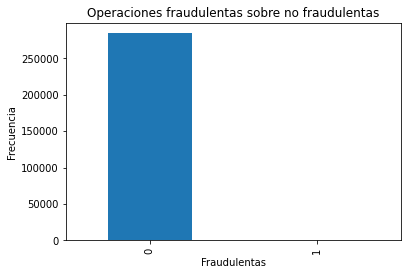

In [55]:
# Contamos cuantas operaciones son verdaderas >>> 0, y cuantas son falsas >>>> 1

count_classes = pd.value_counts(data['Class'], sort = False)
# Método válido para clasificar cuando hay pocas categorias 
# count_classes es una serie
count_classes.plot (kind='bar')
plt.title ("Operaciones fraudulentas sobre no fraudulentas")
plt.xlabel ("Fraudulentas")
plt.ylabel ("Frecuencia")


In [56]:
data.shape

(284807, 31)

<AxesSubplot:ylabel='Frequency'>

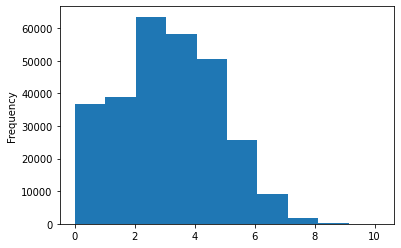

In [57]:
# Pueden aplicarse formulas sobre las columnas de un Data Frame
data['logAmount'] = np.log(data['Amount']+1)
# Para después dibujar un histograma
data['logAmount'].sort_values().plot.hist()

In [58]:
# Escalamos la variable amount  

from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape (-1,1))
data = data.drop (['Time', 'Amount','logAmount'], axis = 1);


In [59]:
# Separamos los datos en dos arrays, uno con las variables X y otro con las variables y
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']
len(y[y.Class ==1]);

In [60]:
# Resampling --> Para casos en los que el sistema está desbalanceado como éste

#  - Undersampling --> Eliminar casos del tipo mayoritario
#  - Oversampling -->  Replicar de forma sintética los casos minoritarios
#  - SMOTE --> Una técnica combinación de las dos anteriores 

# Contamos el número de casos de fraude que existen ¡¡
number_records_fraud = len (data[data.Class==1])
# Y extraemmos los índices donde están los casos de fraude y los de no fraude
fraud_indices = np.array (data[data.Class==1].index)
normal_indices = np.array (data[data.Class==0].index)

In [61]:
print(len(fraud_indices))
print(len(normal_indices))

492
284315


In [62]:
# Obtenemos de forma aleatoria un número de indices de no fraude, igual al de fraude
random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False )
# Unimos en un solo array los indices de fraude con los de no fraude escogidos aleatoriamente
under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])


In [74]:
# Ahora escogemos los valores de dichos indices
under_sample_data = data.iloc[under_sample_indices,:]
# Separamos la X de la y de nuevo
X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class'];
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class'];

In [75]:
X_undersample.shape

(984, 29)

In [76]:
under_sample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1,-0.353229
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1,1.761758
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1,0.606031
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1,-0.117342
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1,-0.349231


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.3, random_state = 0)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split (X_undersample,y_undersample, test_size = 0.3, random_state = 0)
#X_train_under, X_valid_under, y_train_under, y_valid_under = train_test_split (X_train_under,y_train_under, test_size = 0.3, random_state = 0)

In [78]:
X_train.shape

(199364, 29)

In [79]:
y_train_under.shape

(688, 1)

In [80]:
X_test_under.shape

(296, 29)

In [81]:
X_valid_under.shape

(207, 29)

In [82]:
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

In [84]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train_under, y_train_under)
print("score : "+str(MLPC.score(X_train_under,y_train_under)))
y_pred = MLPC.predict(X_test)
print("score : "+str(MLPC.score(X_test,y_pred)))
# Obtenemos valores de recall
recall_acc = recall_score (y_test,y_pred)
recall_acc 

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score : 1.0
score : 1.0


0.9591836734693877

In [95]:
preds = MLPC.predict(X_train)

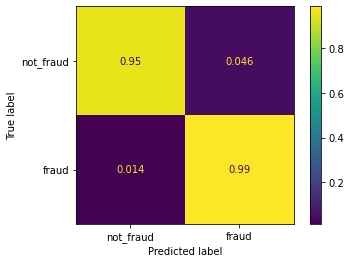

In [96]:
cm = confusion_matrix(y_train, preds, labels=MLPC.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [98]:
recall_score (y_train,preds)

0.9855072463768116

In [99]:
preds = MLPC.predict(X_test)

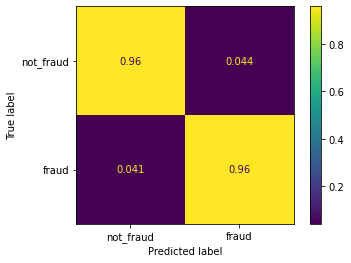

In [100]:
cm = confusion_matrix(y_test, preds, labels=MLPC.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [101]:
recall_score (y_test,preds)

0.9591836734693877

In [90]:
preds = MLPC.predict(X_train)

In [ ]:
cm = confusion_matrix(y_train, preds, labels=MLPC.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [85]:
X_train_under.shape

(688, 29)

In [86]:
model = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth = 10,
    early_stopping_rounds=10,
    learning_rate=0.1,
    tree_method="exact",
    booster='gbtree',
    importance_type='gain',
    # scale up the weight of positive samples
    use_label_encoder=False,
    eval_metric=["error","logloss"]
)

In [48]:
X_train_under2, X_valid_under, y_train_under2, y_valid_under = train_test_split (X_train_under,y_train_under, test_size = 0.3, random_state = 0)

In [55]:
# CPU
train_start_time = time.time()
eval_set=[(X_test,y_pred)]
#model.fit(X_train_under2, np.ravel(y_train_under2),eval_set=eval_set,verbose=False)
model.fit(X_train_under, np.ravel(y_train_under),eval_set=eval_set,verbose=False)
train_end_time = time.time()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 0 seconds


In [56]:
preds = model.predict(X_train_under)

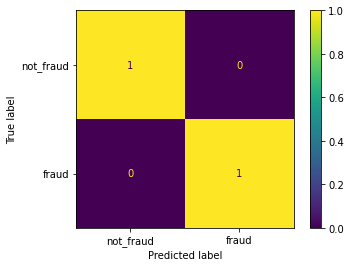

In [57]:
cm = confusion_matrix(y_train_under, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [58]:
preds = model.predict(X_test)

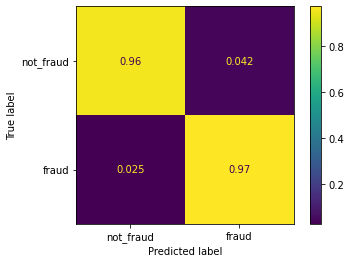

In [59]:
cm = confusion_matrix(y_test, preds, labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [60]:
print("score : train reduced split",str(model.score(X_train_under2,y_train_under2)))
print("score : train reduced ",str(model.score(X_train_under,y_train_under)))
print("score : test reduced",str(model.score(X_test_under,y_test_under)))
print("score : train ",str(model.score(X_train,y_train)))
print("score : test ",str(model.score(X_test,y_test)))

score : train reduced split 1.0
score : train reduced  1.0
score : test reduced 0.9493243243243243
score : train  0.9702251270878722
score : test  0.9627749576988156


In [109]:
nb_components=10

In [139]:
pca = PCA(n_components=nb_components)
X_train_under = pca.fit_transform(X_train_under)


In [140]:
pca.explained_variance_ratio_

array([0.73897894, 0.12782894, 0.05097428, 0.02113794, 0.01575747,
       0.01174958, 0.01129969, 0.01007112, 0.00712293, 0.00507911])

In [141]:
np.sum(pca.explained_variance_ratio_[:5])

0.9546775723383648

In [112]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
1741,-0.354079,0.367338,-0.465640,-2.062526,1.164314,-0.986899,1.661215,-0.563459,-1.902491,0.535226
1474,-0.488296,0.812422,1.670005,0.052304,0.441275,-0.681785,1.041276,-0.449721,-0.094300,-0.026722
744,0.472604,-1.093629,-0.207802,0.924707,-0.734268,-0.664377,0.652470,-0.229109,-0.146100,-0.124628
602,1.160266,-0.140284,0.516423,0.041683,-0.713674,-0.743291,-0.172787,-0.002352,0.118422,-0.015422
1114,-1.139207,0.738313,-0.040919,0.036735,2.023558,3.887694,-0.224574,1.276073,-2.851531,0.861198
